In [17]:
from typing import NamedTuple, Tuple
import seaborn as sns
import matplotlib as mpl
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import cv2 as cv
import pandas as pd
import os
from sklearn.model_selection import train_test_split

In [2]:
mpl.rcParams['figure.dpi'] = 300
sns.set_theme()
sns.set_style("ticks")

# Fundamental functions

In [3]:
def undistort(dc: np.ndarray, k: float, yx: np.ndarray) -> np.ndarray:
    r2 = ((yx - dc) ** 2).sum(axis=1, keepdims=True)
    vu = dc + (yx - dc) / (1 + k * r2)
    return vu


def redistort(
    dc: np.ndarray,  # centre point, *2
    k: float,        # distort parameter aka. lambda
    vu: np.ndarray,  # non-distorted, n * 2
) -> np.ndarray:     # n * 2

    # Extract components for clarity
    xb = vu[:, 0]
    yb = vu[:, 1]
    x0 = dc[0]
    y0 = dc[1]

    # Calculate the radial distance rc for each point
    rc = np.sqrt((xb - x0)**2 + (yb - y0)**2)

    # Ensure that rc is not zero to avoid division by zero
    rc_safe = np.where(rc == 0, 1e-8, rc)

    # Calculate the distorted coordinates using the provided formula
    factor = (1 - np.sqrt(1 - 4 * k * rc_safe**2)) / (2 * k * rc_safe**2)
    x_distorted = x0 + (xb - x0) * factor
    y_distorted = y0 + (yb - y0) * factor

    # Combine the distorted x and y into a single array
    yx = np.vstack((x_distorted, y_distorted)).T

        

def setup_transform(dc: np.ndarray, k: float, mn: Tuple[int, int], scale: float):
    ylong = np.arange(0, mn[0], scale) # Generate values from 0 to mn[0]-1 with a step of "scale"
    xlong = np.arange(0, mn[1], scale)
    yxrect_d3 = np.stack(np.meshgrid(xlong, ylong), axis=-1)
    yxrect = yxrect_d3.reshape((-1, 2))[:, ::-1]

    interp_grid = tuple(dim.ravel() for dim in np.indices(dimensions=mn, sparse=True))

    return {
        'mn_high': yxrect_d3.shape[:2],
        'interp_grid': interp_grid,
        'yxdistort': redistort(dc=dc, k=k, vu=yxrect),
        'yxfixed': undistort(dc=dc, k=k, yx=yxrect),
        'rect_axes': (ylong, xlong),
    }


def distort_image(transform, image: np.ndarray) -> np.ndarray:
    distort_interp = RegularGridInterpolator(
        points=transform['interp_grid'], values=image, bounds_error=False, method='linear'
    )
    distorted = distort_interp(transform['yxdistort'])
    return distorted.reshape((*transform['mn_high'], -1))


def undistort_image(transform, image: np.ndarray) -> np.ndarray:
    undistort_interp = RegularGridInterpolator(
        points=transform['rect_axes'], values=image, bounds_error=False, method='linear'
    )
    undistorted = undistort_interp(transform['yxfixed'])
    return undistorted.reshape((*transform['mn_high'], -1))

def estimate_resolution_loss(mn: Tuple[int, int], dc: np.ndarray, k: float) -> float:
    n = 256
    middle_strip = np.empty((n, 2))
    middle_strip[:, 0] = np.linspace(0, mn[0] - 1, n) # give me n values start from 0 to mn[0] - 1
    middle_strip[:, 1] = mn[1] / 2

    distorted = redistort(dc=dc, k=k, vu=middle_strip)
    y, x = distorted.T
    y = y[np.isfinite(y)]

    res_reduce = mn[0] / (y.max() - y.min())
    return res_reduce

def roundtrip_demo(filename: str) -> None:
    imorig = np.array(Image.open(filename))
    mn = imorig.shape[:2]
    dc = 0.5 * np.array(mn) + 0.1
    k = 3e-5
    res_reduce = estimate_resolution_loss(mn=mn, dc=dc, k=k)
    transform = setup_transform(mn=mn, dc=dc, k=k, scale=res_reduce)

    imdistort = distort_image(transform, imorig / 255)
    imfixed = undistort_image(transform, imdistort)

    fig, (ax_orig, ax_distort, ax_fixed) = plt.subplots(ncols=3, figsize=(20, 10))

    ax_orig.imshow(imorig)
    ax_distort.imshow(imdistort)
    ax_fixed.imshow(imfixed)
    ax_orig.set_title('Original')
    ax_distort.set_title('Distorted')
    ax_fixed.set_title('Corrected')
    plt.show()

# Distort

In [4]:
def distort_given_k_and_image(k: float, clean_image: np.ndarray) -> np.ndarray:

    # Calculate image dimensions and distortion center
    mn = clean_image.shape[:2]
    
    dc = 0.5 * np.array(mn) + 0.1
    
    # Estimate the resolution reduction
    res_reduce = estimate_resolution_loss(mn=mn, dc=dc, k=k)
    
    # Setup transformation
    transform = setup_transform(mn=mn, dc=dc, k=k, scale=res_reduce)
    
    # Normalize the image to range [0, 1]
    clean_image_normalised = clean_image / 255.0 if np.max(clean_image) > 1 else clean_image
    
    # Undistort the image
    distorted_image_normalised = distort_image(transform, clean_image_normalised)
    
    # Rescale the image back to [0, 255]
    distorted_image = (distorted_image_normalised * 255).astype(np.uint8)
    
    return distorted_image


def crop_largest_square_inside_round_shape(image):
    """
    Crop the image to the largest square inside the central round-shaped content,
    ensuring the square is entirely within the non-black content.
    
    Parameters:
    image (numpy.ndarray): An (n, n, 3) array representing the image.
    
    Returns:
    numpy.ndarray: The cropped image.
    """
    # Get the dimensions of the image
    n = image.shape[0]
    
    # Find the non-black pixel coordinates
    non_black_pixels = np.argwhere(image.sum(axis=-1) != 0)
    
    # Calculate the center of the bounding circle (mean of non-black pixels)
    center = non_black_pixels.mean(axis=0).astype(int)
    
    # Calculate the radius of the bounding circle (max distance from center to non-black pixel)
    distances = np.linalg.norm(non_black_pixels - center, axis=1)
    radius = int(distances.max())
    
    # Side length of the largest square that fits inside the circle
    side_length = int(np.sqrt(2) * radius)
    
    # Ensure the side_length is even
    if side_length % 2 != 0:
        side_length -= 1
    
    # Calculate the top-left corner of the square
    half_side = side_length // 2
    start_row = center[0] - half_side
    start_col = center[1] - half_side
    
    # Ensure the crop area is within the image boundaries
    start_row = max(0, start_row)
    start_col = max(0, start_col)
    end_row = min(n, start_row + side_length)
    end_col = min(n, start_col + side_length)
    
    # Crop the image
    cropped_image = image[start_row:end_row, start_col:end_col, :]
    
    return cropped_image

## Single image

In [7]:
# Inputs

clean_image_path = 'SampleImages/Clean/CheckeredFlag.jpg'
k = 1.15e-5

/var/folders/yb/q8pvpkcj757ft6nlg4_hj5080000gn/T/ipykernel_4908/3982626012.py:19: RuntimeWarning: invalid value encountered in sqrt
  ) + 0.5 * (vu - dc) * (1 - np.sqrt(1 - 4 * inner))) / inner
/var/folders/yb/q8pvpkcj757ft6nlg4_hj5080000gn/T/ipykernel_4908/555992641.py:21: RuntimeWarning: invalid value encountered in cast
  distorted_image = (distorted_image_normalised * 255).astype(np.uint8)


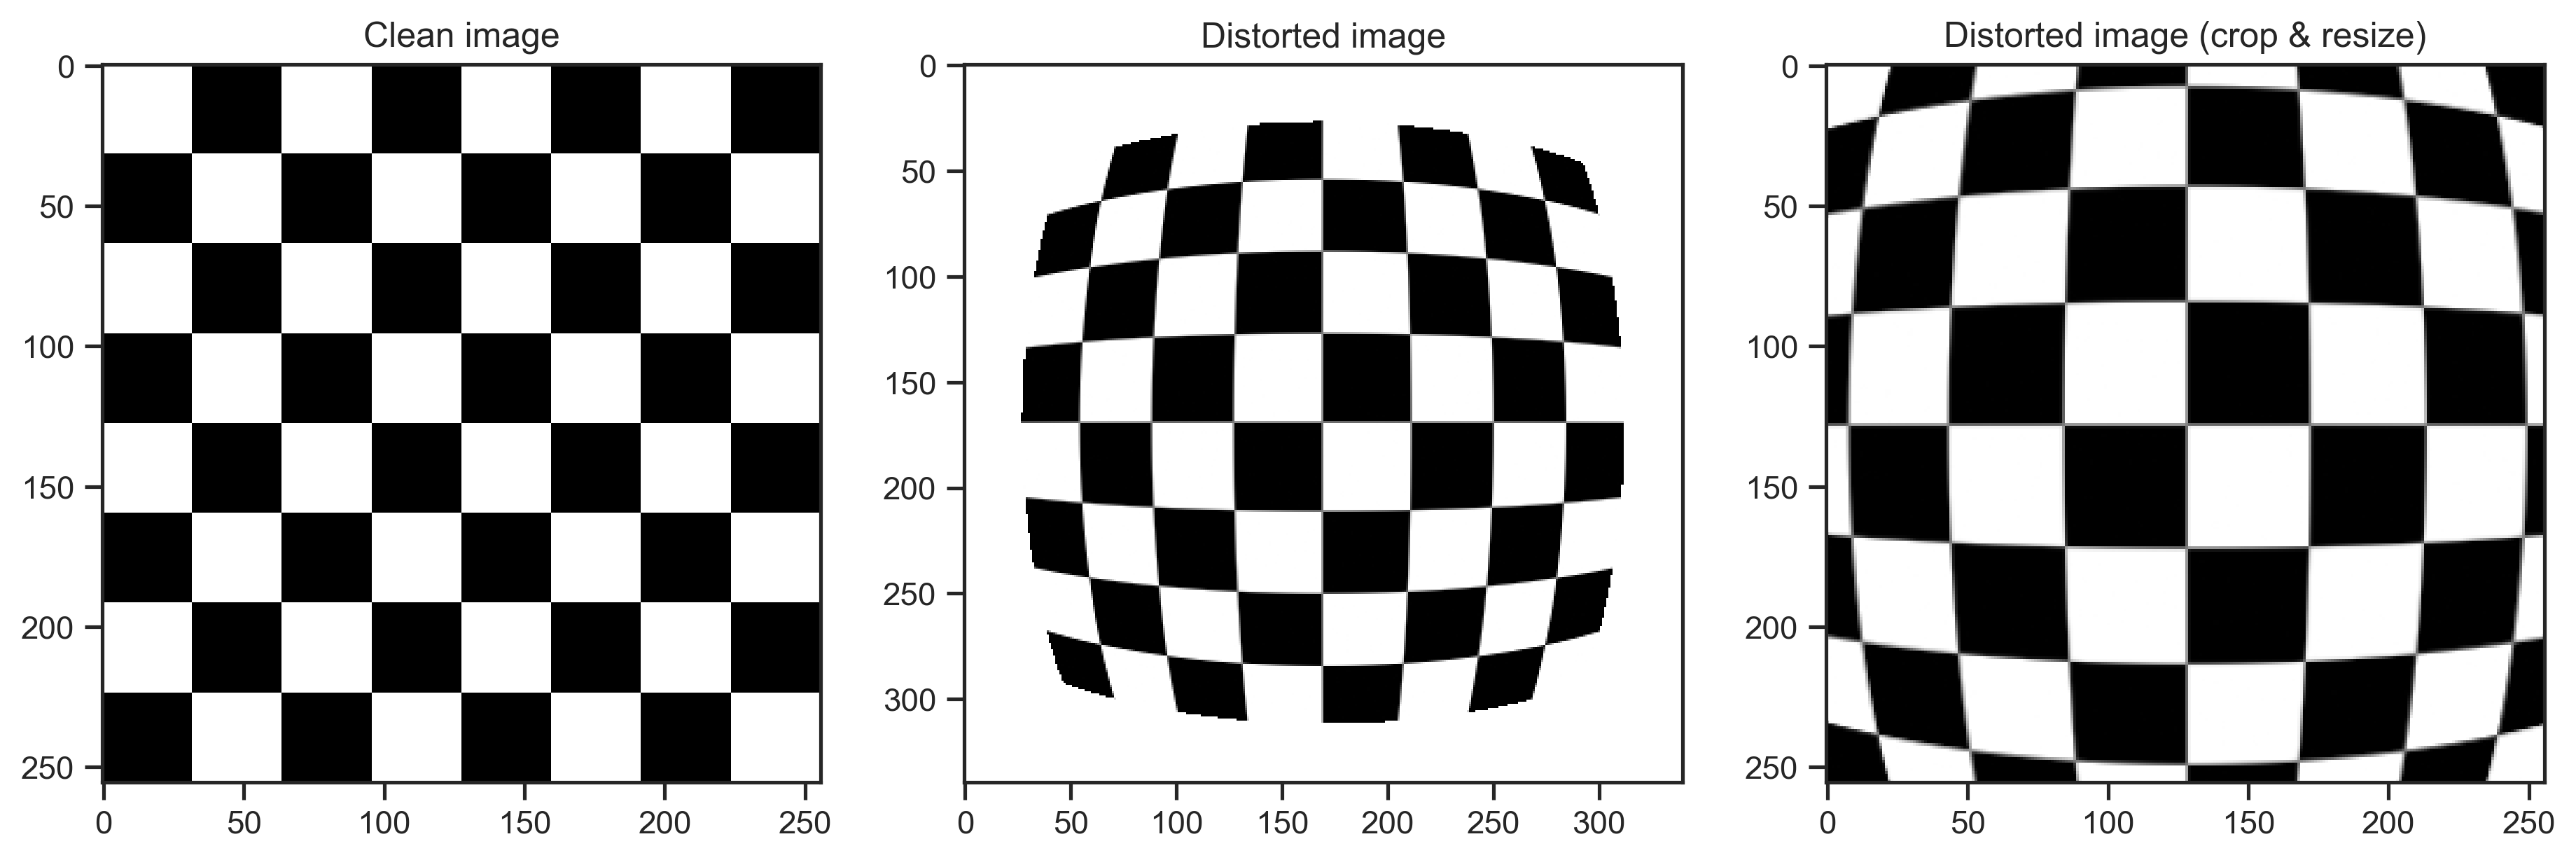

In [11]:
clean_image = np.array(Image.open(clean_image_path))
distorted_image = distort_given_k_and_image(k, clean_image)
distorted_image_crop = crop_largest_square_inside_round_shape(distorted_image)
distorted_image_crop_resize = cv.resize(distorted_image_crop, (256,256))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Clean image")
# plt.axis('off')
plt.imshow(clean_image)

plt.subplot(1, 3, 2)
plt.title("Distorted image")
# plt.axis('off')
plt.imshow(distorted_image)

plt.subplot(1, 3, 3)
plt.title("Distorted image (crop & resize)")
plt.imshow(distorted_image_crop_resize)
# plt.axis('off')
plt.show()

## Show effect of k = 1e-6 to 1e-4

/var/folders/yb/q8pvpkcj757ft6nlg4_hj5080000gn/T/ipykernel_4908/555992641.py:21: RuntimeWarning: invalid value encountered in cast
  distorted_image = (distorted_image_normalised * 255).astype(np.uint8)
/var/folders/yb/q8pvpkcj757ft6nlg4_hj5080000gn/T/ipykernel_4908/3982626012.py:19: RuntimeWarning: invalid value encountered in sqrt
  ) + 0.5 * (vu - dc) * (1 - np.sqrt(1 - 4 * inner))) / inner


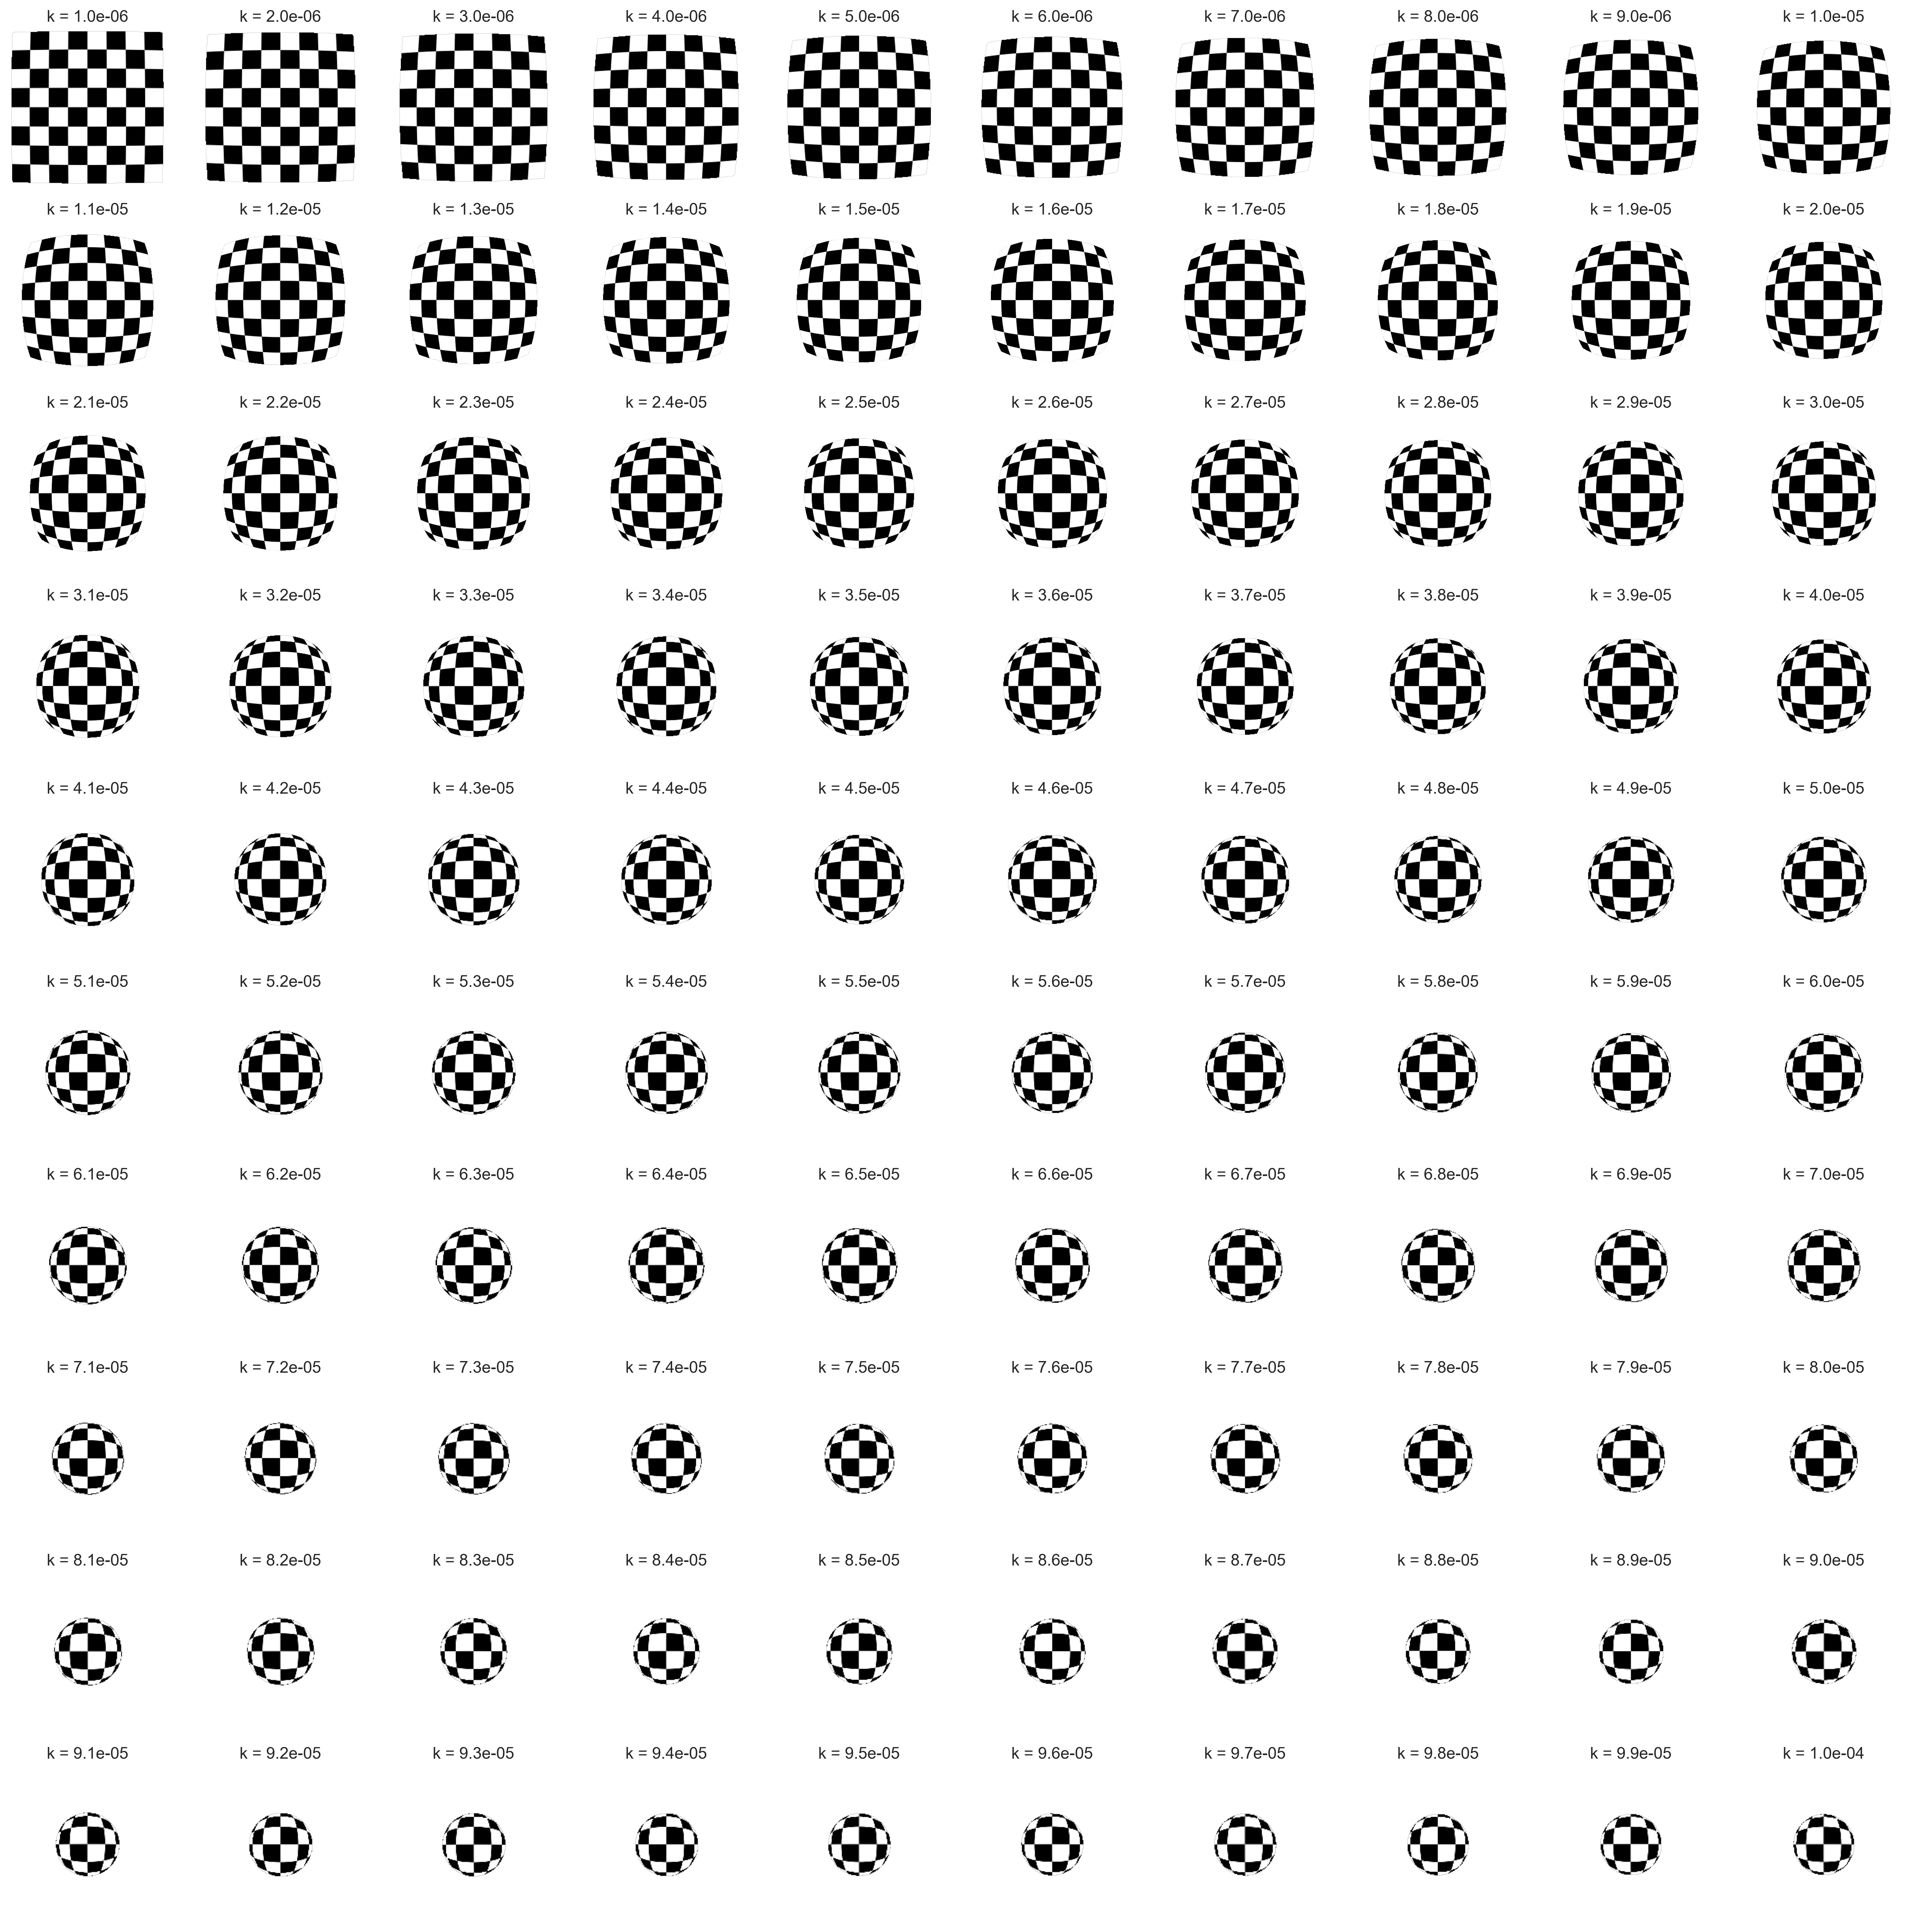

In [16]:
# Specify the number of k values
amount = 100

# Generate the specified amount of k values between 1e-5 and 3e-5
k_values = np.linspace(1e-6, 1e-4, amount)

plt.figure(figsize=(20, 20))
for i, k in enumerate(k_values, 1):
    distorted_image = distort_given_k_and_image(k, clean_image)
    plt.subplot(10, 10, i)  # Adjust the number of rows and columns as needed
    plt.imshow(distorted_image)
    plt.title(f"k = {k:.1e}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Synthesise dataset

## Create .csv file

In [18]:
# Inputs

num_rows = 9900 # = number of clean images you have in a folder * 99

# Destination

output_csv_file_path = "df_platform.csv"

In [19]:
np.random.seed(42)

# Create the "id1" column
id1_values = [f"{1000000 + i // 99:07}" for i in range(num_rows)]

# Create the "id2" column
id2_values = [f"{2000000 + i:07}" for i in range(num_rows)]

# Create the "level" column
levels = [str(i % 99) for i in range(num_rows)]

# Create the "k" column based on the "level"
k_values = []
for i in range(num_rows):
    level = i % 99
    k = np.random.uniform((level + 1) * 1e-6, (level + 2) * 1e-6)
    k_values.append(k)

# Create the DataFrame
df = pd.DataFrame({
    "id1": id1_values,
    "id2": id2_values,
    "k": k_values,
    "level": levels
})

# # Save to CSV
df.to_csv(output_csv_file_path, index=False)

df

id1      id2         k level
0     1000000  2000000  0.000001     0
1     1000000  2000001  0.000003     1
2     1000000  2000002  0.000004     2
3     1000000  2000003  0.000005     3
4     1000000  2000004  0.000005     4
...       ...      ...       ...   ...
9895  1000099  2009895  0.000095    94
9896  1000099  2009896  0.000097    95
9897  1000099  2009897  0.000098    96
9898  1000099  2009898  0.000099    97
9899  1000099  2009899  0.000099    98

[9900 rows x 4 columns]

## Synthesise entire folder

In [25]:
# Input

input_folder = "CleanPlatformImages"
csv_file = "df_platform.csv"

# Destination

output_folder = "DistortedPlatformImages"

In [27]:
# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read the CSV file
df = pd.read_csv(csv_file)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    id1 = int(row['id1'])
    id2 = int(row['id2']) 
    k = row['k']      

    input_image_path = os.path.join(input_folder, f"{id1}.jpg")
    output_image_path = os.path.join(output_folder, f"{id2}.jpg")

    clean_image = np.array(Image.open(input_image_path))

    distorted_image = distort_given_k_and_image(k, clean_image)
    distorted_image_crop = crop_largest_square_inside_round_shape(distorted_image)
    distorted_image_crop_resize = cv.resize(distorted_image_crop, (256,256))
    distorted_image_crop_resize_bgr = cv.cvtColor(distorted_image_crop_resize, cv.COLOR_RGB2BGR)
    cv.imwrite(output_image_path, distorted_image_crop_resize_bgr)

    if index % 1000 == 0:
        print(f"Done: {index}")

print("Processing complete.")

## Prepare `df_train`, `df_val`, `df_test`

In [28]:
df = pd.read_csv(csv_file)
df_classi = df[['id2', 'k', 'level']]

# First, split off 20% of the data for validation + testing (0.2)
df_train, df_temp = train_test_split(df_classi, test_size=0.2, stratify=df_classi['level'], random_state=42)

# Then split the remaining 20% into validation (10%) and testing (10%)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['level'], random_state=42)

df_train.to_csv('df_platform_train.csv', index=False)
df_val.to_csv('df_platform_val.csv', index=False)
df_test.to_csv('df_platform_test.csv', index=False)